## MovieRec

In this notebook, I'll build a deep learning model movie recommendations system on the MovieLens 20M dataset.

In [1]:
from fastai import *
from fastai.collab import *
from fastai.tabular import *

### Loading MovieLens 20m dataset
Download [link](http://files.grouplens.org/datasets/movielens/ml-20m.zip) and dataset [readme.](http://files.grouplens.org/datasets/movielens/ml-20m-README.html)

In [2]:
path = 'data/'
ml20 = path + 'ml-20m/' 
!ls {ml20}

README.txt	   genome-tags.csv  movies.csv	 tags.csv
genome-scores.csv  links.csv	    ratings.csv


#### ratings.csv

In [3]:
ratings = pd.read_csv(ml20 + 'ratings.csv', encoding='latin-1')
print('Size:', len(ratings))
ratings.head(2)

Size: 20000263


,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676


#### movies.csv

In [4]:
movies = pd.read_csv(ml20 + 'movies.csv', encoding='latin-1')
print('Size:', len(movies))
movies.head(2)

Size: 27278


,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy


#### links.csv

In [5]:
links = pd.read_csv(ml20 + 'links.csv', encoding='latin-1')
print('Size:', len(links))
links.head(2)

Size: 27278


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0


#### Or load 100k dataset

In [6]:
ml100 = path + 'ml-100k/' 
r_names = ['userId','movieId','rating','timestamp']
m_names = ['movieId', 'title', 'date', 'N', 'url', *[f'g{i}' for i in range(19)]]
#ratings = pd.read_csv(ml100 + 'u.data', delimiter='\t', header=None, names=r_names)
#movies = pd.read_csv(ml100 + 'u.item',  delimiter='|', encoding='latin-1', header=None, names=m_names)

### Loading my [IMDb ratings](https://www.imdb.com/user/ur15834927/ratings)

In [7]:
my_ratings = pd.read_csv(path + 'my_ratings.csv', encoding='latin-1')
my_ratings = my_ratings.sort_values('Date Rated').reset_index(drop=True)
print('Size:', len(my_ratings))

Size: 568


#### First and last movie I rated

In [8]:
my_ratings.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig"


In [9]:
my_ratings.describe().round(decimals=1)

,Your Rating,IMDb Rating,Runtime (mins),Year,Num Votes
count,568.0,568.0,565.0,568.0,568.0
mean,8.0,7.6,109.4,2002.2,323541.1
std,1.9,0.9,37.7,10.3,332702.2
min,1.0,1.6,8.0,1942.0,13.0
25%,7.0,7.1,96.0,1999.8,84620.5
50%,8.0,7.7,108.0,2005.0,215472.0
75%,10.0,8.1,125.0,2008.0,454300.2
max,10.0,9.5,533.0,2014.0,2034334.0


### Format my_ratings

#### Add userId, rating, timestamp and imdbId to my_ratings

In [10]:
my_ratings['userId'] = max(ratings['userId']) + 1
my_ratings['rating'] = my_ratings['Your Rating'] / 2
my_ratings['timestamp'] = my_ratings['Date Rated'].astype('datetime64[ns]').astype('int64')//1000000000
my_ratings['imdbId'] = my_ratings['Const'].apply(lambda x: x[2:]).map(int)
my_ratings.iloc[[0, -1]]

,Const,Your Rating,Date Rated,Title,URL,Title Type,IMDb Rating,Runtime (mins),Year,Genres,Num Votes,Release Date,Directors,userId,rating,timestamp,imdbId
0,tt0111161,10,2007-08-12,The Shawshank Redemption,https://www.imdb.com/title/tt0111161/,movie,9.3,142.0,1994,Drama,2034334,1994-09-10,Frank Darabont,138494,5.0,1186876800,111161
567,tt2397535,10,2015-11-28,Predestination,https://www.imdb.com/title/tt2397535/,movie,7.5,97.0,2014,"Drama, Mystery, Sci-Fi, Thriller",218780,2014-03-08,"Michael Spierig, Peter Spierig",138494,5.0,1448668800,2397535


#### Merge my_ratings with links and select only necessary columns

In [11]:
my_movies = my_ratings.merge(links, on='imdbId')[['userId', 'movieId', 'rating', 'timestamp']]
my_movies.tail(2)

,userId,movieId,rating,timestamp
495,138494,77800,5.0,1448496000
496,138494,114935,5.0,1448668800


#### Concat my ratings with all ratings

In [12]:
all_ratings = pd.concat([ratings, my_movies], ignore_index=True)
all_ratings.tail(2)

,userId,movieId,rating,timestamp
20000758,138494,77800,5.0,1448496000
20000759,138494,114935,5.0,1448668800


#### Merge titles

In [13]:
all_ratings['order'] = all_ratings.index
all_ratings = pd.merge(all_ratings, movies[['movieId', 'title']])
all_ratings = all_ratings.sort_values('order')
all_ratings = all_ratings.reset_index(drop=True)
all_ratings = all_ratings.drop(columns='order')
#all_ratings.to_csv(path + 'all_ratings.csv', index=False)

all_ratings.tail(2)

,userId,movieId,rating,timestamp,title
20000758,138494,77800,5.0,1448496000,Four Lions (2010)
20000759,138494,114935,5.0,1448668800,Predestination (2014)


In [19]:
print(f'Nr of missing values: {movies.isnull().values.sum()}')

Nr of missing values: 0


### 500 most viewed movies

In [14]:
top500 = ratings.groupby('movieId').count().sort_values('userId', ascending=False)[:500]
idx = pd.Index(movies['movieId']).get_indexer(top500.index.values)
top500 = movies.iloc[idx].reset_index(drop=True)
top500.head()

,movieId,title,genres
0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War
2,318,"Shawshank Redemption, The (1994)",Crime|Drama
3,593,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,480,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller


In [15]:
my_ratings = all_ratings[all_ratings.userId == 138494]
print(f'I have seen {sum(top500.movieId.isin(my_ratings.movieId))} out of top 500')

I have seen 132 out of top 500


### One Hot Encode movie genres

In [16]:
top_ohe = top500.copy()
my_ohe = movies[movies.movieId.isin(my_ratings.movieId.values)].copy()

for i in top_ohe.index:
    raw = top_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        top_ohe.loc[i, w] = True

for i in my_ohe.index:
    raw = my_ohe.loc[i, 'genres']
    multy = raw.split('|')
    for w in multy:
        my_ohe.loc[i, w] = True

top_ohe.fillna(False, inplace=True)
my_ohe.fillna(False, inplace=True)

top_ohe.head(2)

,movieId,title,genres,Comedy,Crime,Drama,Thriller,Romance,War,Horror,...,Sci-Fi,Animation,Children,Fantasy,IMAX,Mystery,Western,Musical,Film-Noir,Documentary
0,296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,True,True,True,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,356,Forrest Gump (1994),Comedy|Drama|Romance|War,True,False,True,False,True,True,False,...,False,False,False,False,False,False,False,False,False,False


### Find most frequent genres

In [17]:
genres = sorted(list(top_ohe.columns[3:]), reverse=True)
n_groups = len(genres)

top_count = [sum(top_ohe[g]) for g in genres]
my_count = [sum(my_ohe[g]) for g in genres]

### Plot genre frequencies

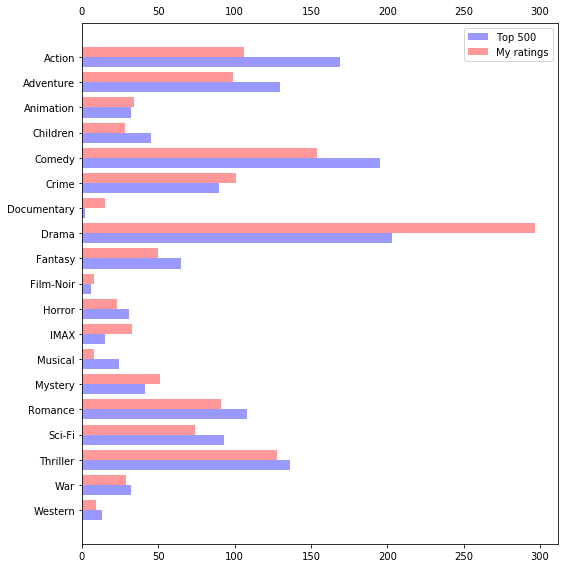

In [18]:
fig, ax = plt.subplots(figsize=(8, 8))

index = np.arange(n_groups)
bar_width = 0.4

rects1 = ax.barh(index - bar_width / 2, top_count, bar_width, alpha=0.4, color='b', label='Top 500')
rects2 = ax.barh(index + bar_width / 2, my_count, bar_width, alpha=0.4, color='r', label='My ratings')

ax.set_yticks(np.arange(len(genres)))
ax.set_yticklabels(genres)
ax.tick_params(labeltop=True, labelright=False)
ax.legend()

fig.tight_layout()
plt.show()

### Collaborative filtering

In [ ]:
data = CollabDataBunch.from_df(all_ratings, seed=1, item_name='title')
data.show_batch(2)

In [ ]:
learn = collab_learner(data, n_factors=50, y_range=(0.,5.))

In [ ]:
learn.fit_one_cycle(1, 5e-3, wd=0.1)

In [ ]:
learn.save('20m_dotprod')
#learn.load('dotprod')

### Interpretation

In [ ]:
learn.model

#### Movie mean rating

In [ ]:
means = all_ratings.groupby('title')['rating'].mean().round(2)
means.head()

#### Movie Bias

In [ ]:
movie_bias = learn.bias(top_movies, is_item=True)

In [ ]:
stats = [(i, means[i], np.round(e.item(), decimals=2)) for i, e in zip(top_movies, movie_bias)]
print('title, mean ratings, bias')
stats[:5]